In [1]:
import numpy as np
import pandas as pd
import spacy
import calamancy
import string
import sklearn
import re
from wordcloud import WordCloud
from lemmatizer import combined_dictionary
import importlib
import all_links
import brands
import my_stopwords

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline


nlp_en = spacy.load("en_core_web_sm")
nlp_tl = calamancy.load("tl_calamancy_md-0.1.0")


c:\Users\Yissus\AppData\Local\Programs\Python\Python311\Lib\site-packages\spacy\util.py:918: UserWarning: [W094] Model 'tl_calamancy_md' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.2,<3.8.0
  warnings.warn(warn_msg)


In [2]:
df = pd.read_csv('merged-set.csv', encoding = "ISO-8859-1")
df.shape

(873, 2)

In [3]:
df.drop_duplicates(inplace=True)
df.shape

(854, 2)

In [4]:
df.isnull().sum()

label      0
message    0
dtype: int64

In [5]:
print(nlp_tl.Defaults.stop_words)


{'ka', 'naging', 'bakit', 'ginagawa', 'noon', 'hindi', 'bababa', 'tatlo', 'ay', 'kanino', 'din', 'kailanman', 'una', 'pero', 'dito', 'huwag', 'marapat', 'pumupunta', 'anumang', 'sarili', 'ibaba', 'pangalawa', 'aming', 'aking', 'tulad', 'akin', 'tungkol', 'ibig', 'panahon', 'kulang', 'maging', 'paano', 'inyong', 'para', 'pumunta', 'narito', 'paggawa', 'sabihin', 'walang', 'kami', 'marami', 'nilang', 'bilang', 'gumawa', 'pa', 'ng', 'sabi', 'mayroon', 'ilagay', 'napaka', 'ibabaw', 'iyon', 'pagkakaroon', 'pagkatapos', 'pababa', 'iyo', 'likod', 'bawat', 'at', 'hanggang', 'nasaan', 'kapag', 'lamang', 'dalawa', 'sino', 'ginawang', 'gusto', 'makita', 'kanyang', 'ginawa', 'ano', 'pareho', 'kaya', 'kaysa', 'atin', 'bago', 'kanila', 'ikaw', 'kanilang', 'nakita', 'pataas', 'nito', 'ating', 'sa', 'lima', 'minsan', 'am', 'karamihan', 'kailangan', 'ko', 'maaaring', 'muli', 'habang', 'kanya', 'isang', 'maaari', 'kapwa', 'tayo', 'na', 'gayunman', 'kumuha', 'ang', 'ilalim', 'nabanggit', 'ilan', 'ngayon'

In [6]:
print(nlp_en.Defaults.stop_words)


{'an', 'since', 'so', 'seeming', 'seem', 'without', 'my', 'our', 'n’t', 'yourself', 'those', 'five', 'over', 'many', 'whom', 'sixty', 'either', 'empty', 'hers', 'for', 'four', 'this', 'beyond', 'only', 'per', 'to', 'used', 'next', 'your', 'during', 'or', 'most', 'yours', 'does', "'s", 'very', 'whence', 'doing', 'every', '‘m', 'mine', 'several', 'thereafter', 'towards', 'sometimes', 'ten', 'nobody', 'while', 'whereas', 'am', 'everything', 'always', 'using', 'about', 'how', 'that', 'further', 'make', 'whatever', 'throughout', 'well', 'fifty', 'say', 'latterly', 'not', 'and', 'him', 'nor', 'just', 'even', 'wherein', 'before', 'until', 'nothing', 'he', 'almost', 'anywhere', 'anyway', 'itself', 'via', 'upon', 'own', 'less', 'is', 'their', 'been', 'neither', 'themselves', 'the', 'we', "'re", 'beforehand', 'thereby', 'his', 'perhaps', 'was', 'name', 'out', 'twenty', 'hundred', 'anyone', 'anything', 'nevertheless', 'any', 'behind', '’re', 'whereupon', 'n‘t', 'her', 'me', 'part', 'keep', 'from'

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
message_bow = cv.fit_transform(df['message'])


In [8]:
df.head()


,label,message
0,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ..."
1,spam,"My god, at least 999P rewards waiting for you\..."
2,spam,"DEAR VIP <REAL NAME>, No. 1 Online Sabong Site..."
3,spam,"<REAL NAME>! Today, you can win the iphone14PR..."
4,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ..."


In [9]:
df.tail()

,label,message
868,ham,"Kulang pa ang load, Ka-TM? Humiram na ng extra..."
869,ham,"Sorry, hindi sapat ang iyong points para ma-re..."
870,ham,The package 8255-1673-EKXG is out for delivery...
871,ham,"Hey, GOMO Fam! We wish to inform you that ther..."
872,ham,"NDRRMC: (2:05 PM, 22Jul21) Orange Rainfall War..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 854 entries, 0 to 872
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    854 non-null    object
 1   message  854 non-null    object
dtypes: object(2)
memory usage: 20.0+ KB


In [11]:
df.describe()

,label,message
count,854,854
unique,2,854
top,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ..."
freq,542,1


In [12]:
df.groupby('label').describe().T

label                                                         ham  \
message count                                                 312   
        unique                                                312   
        top      good morning sir. <REAL NAME>. this is <REAL ...   
        freq                                                    1   

label                                                        spam  
message count                                                 542  
        unique                                                542  
        top     Welcome ! your have P1222 for S!ot , \r\nWeb: ...  
        freq                                                    1

In [13]:
df['length'] = df['message'].apply(len)
df.head()

,label,message,length
0,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ...",70
1,spam,"My god, at least 999P rewards waiting for you\...",82
2,spam,"DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...",214
3,spam,"<REAL NAME>! Today, you can win the iphone14PR...",161
4,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ...",69


In [14]:
# Count the frequency of top 5 messages.
df['message'].value_counts().rename_axis(['message']).reset_index(name='counts').head()

,message,counts
0,"Welcome ! your have P1222 for S!ot , \r\nWeb: ...",1
1,Para mabalik yung hihiramin mo.,1
2,"Day handa kana sa tayuman na ako,TX kita pag l...",1
3,Labas kna nak,1
4,Day e chat mo labas sa akin low bat mama mo,1


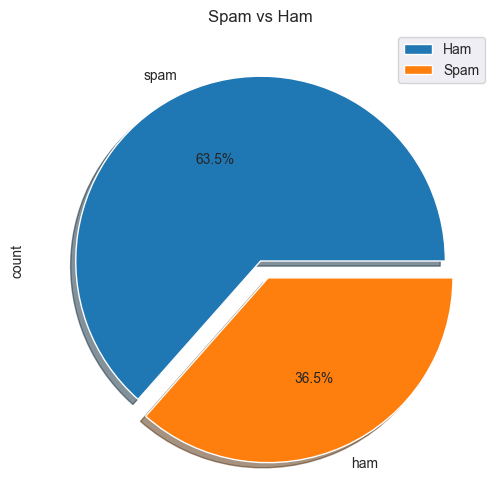

In [15]:
df["label"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

Text(0, 0.5, 'Frequency')

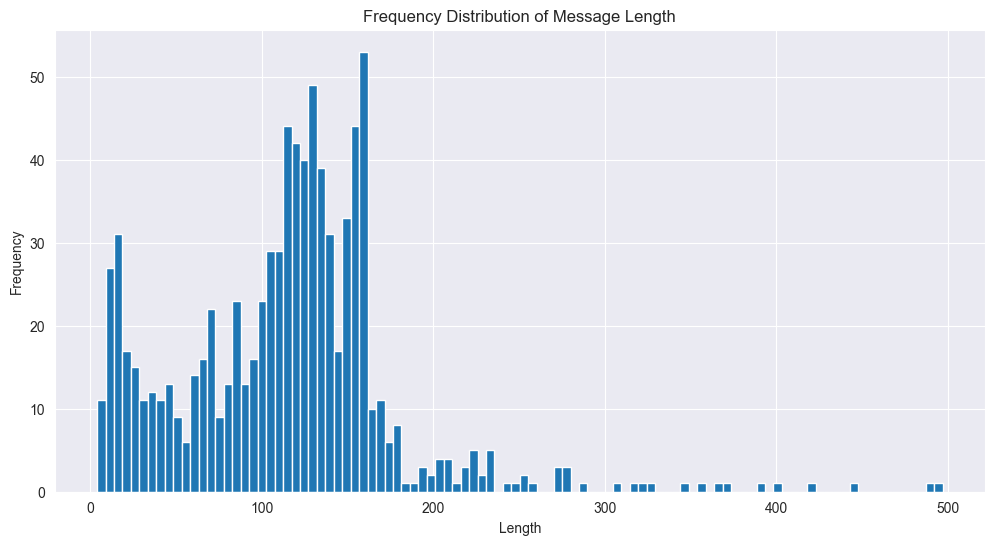

In [16]:
plt.figure(figsize=(12,6))
df['length'].plot(bins=100, kind='hist') # with 100 length bins (100 length intervals) 
plt.title("Frequency Distribution of Message Length")
plt.xlabel("Length")
plt.ylabel("Frequency")

In [17]:
df['length'].describe()

count    854.000000
mean     114.056206
std       64.460274
min        4.000000
25%       73.000000
50%      119.000000
75%      148.000000
max      497.000000
Name: length, dtype: float64

In [18]:
df[df['length'] == 497]['message'].iloc[0]

'Hi <REAL NAME>. Sorry, we are unable to activate your Virtual Pag-IBIG Account. To help you with your activation request, we have sent the reason/s why we were unable to activate your account to your email address <REAL NAME>*******@gm***.com. Once you have addressed these reasons, you may resubmit your Virtual Pag-IBIG Account activation request conveniently through a link we provided in the same email. We look forward to serving you online, anytime, anywhere via Virtual Pag-IBIG. Thank you.'

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

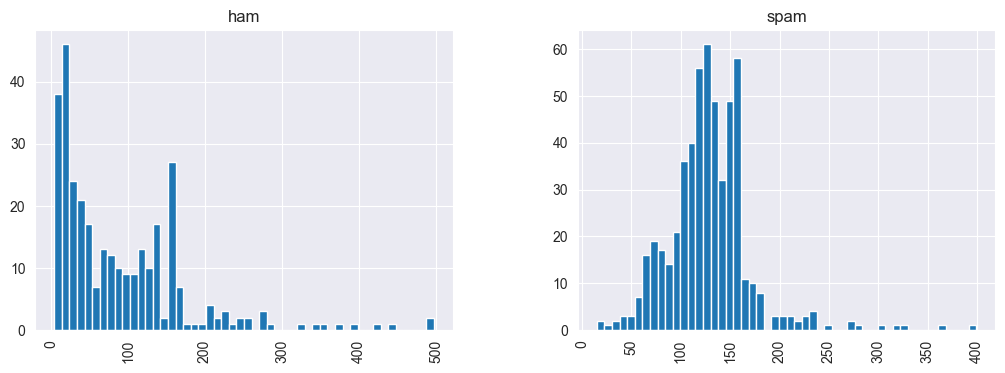

In [19]:
df.hist(column='length', by='label', bins=50,figsize=(12,4))

In [20]:
print(my_stopwords.custom_stopwords)

['po', 'lang', 'kang', 'kayo', 'naman', 'rin', 'for', 'ba', 'mo', 'mas', 'yun', 'yung', 'yon', 'iyon', 'dyan', 'yo', 'sir', 'mam', 'hi', 'hello', 'pwede', 'kita', 'si', 'nag', 'mag', 'yan', 'iyan']


In [21]:
#dropping of links
importlib.reload(all_links)
df['processed_message'] = df['message'].apply(lambda message: ' '.join(word for word in message.split() if all(url not in word for url in all_links.list_links)))

# Display the modified DataFrame
print(df['processed_message'])


0      Welcome ! your have P1222 for S!ot , Web: 11y....
1      My god, at least 999P rewards waiting for you ...
2      DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...
3      <REAL NAME>! Today, you can win the iphone14PR...
4      Welcome ! your have P1222 for S!ot , Web: grea...
                             ...                        
868    Kulang pa ang load, Ka-TM? Humiram na ng extra...
869    Sorry, hindi sapat ang iyong points para ma-re...
870    The package 8255-1673-EKXG is out for delivery...
871    Hey, GOMO Fam! We wish to inform you that ther...
872    NDRRMC: (2:05 PM, 22Jul21) Orange Rainfall War...
Name: processed_message, Length: 854, dtype: object


In [22]:
#dropping of brands
importlib.reload(brands)
lowercase_brands = [brand.lower() for brand in brands.all_brands]

# Apply the transformation to the 'message' column
df['processed_message'] = df['processed_message'].apply(
    lambda message: ' '.join(word for word in message.split() if all(brand not in word.lower() for brand in lowercase_brands))
)

print(df['processed_message'])





0      Welcome ! your have P1222 for S!ot , Web: 11y....
1      My god, at least 999P rewards waiting for you ...
2      DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...
3      <REAL NAME>! Today, you can win the iphone14PR...
4      Welcome ! your have P1222 for S!ot , Web: grea...
                             ...                        
868    Kulang pa ang load, Humiram na ng extrang P20 ...
869    Sorry, hindi sapat ang iyong points para ma-re...
870    The package 8255-1673-EKXG is out for delivery...
871    Hey, Fam! We wish to inform you that there wil...
872    (2:05 PM, 22Jul21) Orange Rainfall Warning sa ...
Name: processed_message, Length: 854, dtype: object


In [23]:
def text_preprocess(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """

    nopunc = mess.replace("<REAL NAME>", "")
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    nopunc = nopunc.lower()
    
    # Now just remove any stopwords and non alphabets
    nostop=[word for word in nopunc.split() if word.lower() not in nlp_tl.Defaults.stop_words and word.lower() not in nlp_en.Defaults.stop_words and word.lower() not in ["real", "name"] and word.lower() not in my_stopwords.custom_stopwords and word.isalpha()]
   
    
    return nostop

In [24]:
df['processed_message'] = df['processed_message'].apply(lambda message: ' '.join(text_preprocess(message)))
print(df['processed_message'])

0                             welcome sot web good luckc
1                  god rewards waiting uri best baraha r
2      dear vip online sabong site sbet register play...
3      today win earning ton cash prizes w receive si...
4                  welcome sot web greatslife good lucku
                             ...                        
868    load humiram extrang load mababang service fee...
869    sorry sapat points maredeem reward pang offers...
870    package delivery today prepare cash payment re...
871    hey fam wish inform system activity july mn ap...
872    pm orange rainfall warning tarlac pampanga bul...
Name: processed_message, Length: 854, dtype: object


In [25]:
def lemmatize_text(text, language='en'):
    if language == 'en':
        doc = nlp_en(text)
    elif language == 'tl':
        doc = nlp_tl(text)
    else:
        raise ValueError("Unsupported language. Use 'en' for English or 'tl' for Tagalog.")
    
    # Lemmatize the entire text
    lemmatized_text = " ".join([token.lemma_ for token in doc if token.is_alpha])
    
    return lemmatized_text

# Applying lemmatization to the 'processed_message' column
df['processed_message'] = df['processed_message'].apply(lambda x: lemmatize_text(x))
print(df['processed_message'])


0                             welcome sot web good luckc
1                      god reward wait uri good baraha r
2      dear vip online sabong site sbet register play...
3      today win earn ton cash prize w receive signup...
4                  welcome sot web greatslife good lucku
                             ...                        
868    load humiram extrang load mababang service fee...
869    sorry sapat points maredeem reward pang offer ...
870    package delivery today prepare cash payment re...
871    hey fam wish inform system activity july mn ap...
872    pm orange rainfall warn tarlac pampanga bulaca...
Name: processed_message, Length: 854, dtype: object


In [26]:
#lemmatizing some words
def custom_lemmatizer(text):
    for key, value in combined_dictionary.items():
        # Split the key into variations
        variations = [v.strip() for v in key.split(',') or (",")]
        
        # Create a regular expression pattern with word boundaries for each variation
        pattern = '|'.join(r'\b' + re.escape(v) + r'\b' for v in variations)
        
        # Use re.sub with the pattern for replacement
        text = re.sub(pattern, value, text, flags=re.IGNORECASE)
   
    return text

In [27]:
df['processed_message'] = df['processed_message'].apply(custom_lemmatizer)
print(df['processed_message'])

0                             welcome sot web good luckc
1                      god reward wait uri good baraha r
2      dear vip online sabong site sbet register play...
3      today win earn ton cash prize with receive sig...
4                  welcome sot web greatslife good lucku
                             ...                        
868    load humiram extrang load mababang service fee...
869    sorry sapat points maredeem reward pang offer ...
870    package delivery today prepare cash payment re...
871    hey fam wish inform system activity july mn ap...
872    pm orange rainfall warn tarlac pampanga bulaca...
Name: processed_message, Length: 854, dtype: object


In [28]:
spam_messages = df[df["label"] == "spam"]["processed_message"]
ham_messages = df[df["label"] == "ham"]["processed_message"]
print("No of spam messages : ",len(spam_messages))
print("No of ham messages : ",len(ham_messages))

No of spam messages :  542
No of ham messages :  312


In [29]:
df['processed_message'] = df['processed_message'].apply(lambda message: ' '.join(text_preprocess(message)))
print(df['processed_message'])

0                             welcome sot web good luckc
1                      god reward wait uri good baraha r
2      dear vip online sabong site sbet register play...
3      today win earn ton cash prize receive signup b...
4                  welcome sot web greatslife good lucku
                             ...                        
868    load humiram extrang load mababang service fee...
869    sorry sapat points maredeem reward pang offer ...
870    package delivery today prepare cash payment re...
871    hey fam wish inform system activity july mn ap...
872    pm orange rainfall warn tarlac pampanga bulaca...
Name: processed_message, Length: 854, dtype: object


In [30]:
df['processed_message'].head()

0                           welcome sot web good luckc
1                    god reward wait uri good baraha r
2    dear vip online sabong site sbet register play...
3    today win earn ton cash prize receive signup b...
4                welcome sot web greatslife good lucku
Name: processed_message, dtype: object

In [31]:
spam_words = ' '.join(df[df["label"] == "spam"]["processed_message"]).split()

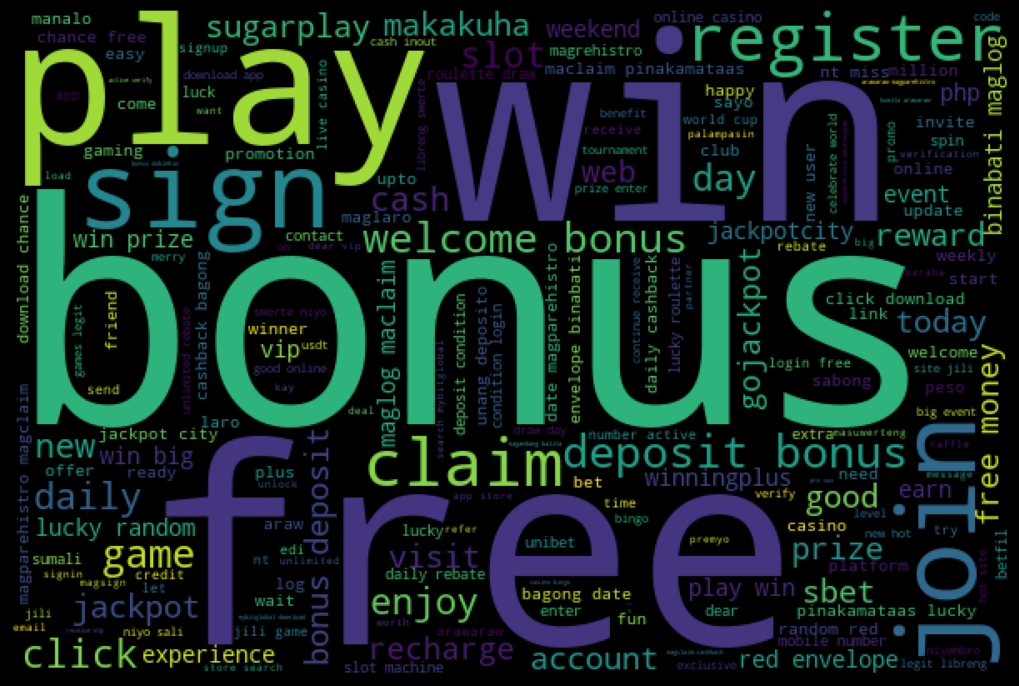

In [32]:
spam_wordcloud = WordCloud(width=600, height=400).generate(' '.join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [33]:
# This may take a while...
ham_words = ' '.join(df[df["label"] == "ham"]["processed_message"]).split()

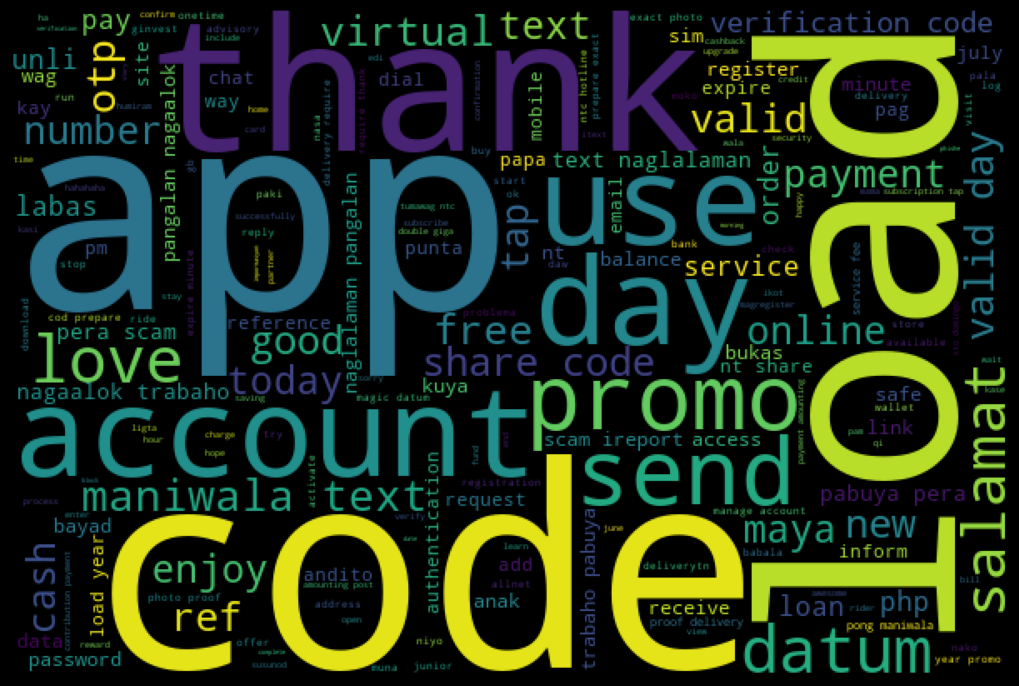

In [34]:
ham_wordcloud = WordCloud(width=600, height=400).generate(' '.join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [35]:

print (df)

    label                                            message  length  \
0    spam  Welcome ! your have P1222 for S!ot , \r\nWeb: ...      70   
1    spam  My god, at least 999P rewards waiting for you\...      82   
2    spam  DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...     214   
3    spam  <REAL NAME>! Today, you can win the iphone14PR...     161   
4    spam  Welcome ! your have P1222 for S!ot , \r\nWeb: ...      69   
..    ...                                                ...     ...   
868   ham  Kulang pa ang load, Ka-TM? Humiram na ng extra...     272   
869   ham  Sorry, hindi sapat ang iyong points para ma-re...     221   
870   ham  The package 8255-1673-EKXG is out for delivery...     140   
871   ham  Hey, GOMO Fam! We wish to inform you that ther...     371   
872   ham  NDRRMC: (2:05 PM, 22Jul21) Orange Rainfall War...     160   

                                     processed_message  
0                           welcome sot web good luckc  
1                    

In [36]:
df.head()

,label,message,length,processed_message
0,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ...",70,welcome sot web good luckc
1,spam,"My god, at least 999P rewards waiting for you\...",82,god reward wait uri good baraha r
2,spam,"DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...",214,dear vip online sabong site sbet register play...
3,spam,"<REAL NAME>! Today, you can win the iphone14PR...",161,today win earn ton cash prize receive signup b...
4,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ...",69,welcome sot web greatslife good lucku


In [37]:
# Creating the Bag of Words

# Note the here we are passing already process messages (after removing punctuations and stopwords)

vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(df['processed_message'])

print("20 Bag of Words (BOW) Features: \n")
print(vectorizer.get_feature_names_out()[0:20])

print("\nTotal number of vocab words : ",len(vectorizer.vocabulary_))

20 Bag of Words (BOW) Features: 

['aalis' 'abalang' 'abangan' 'abanger' 'abroad' 'abs' 'abutin' 'ac'
 'accept' 'access' 'account' 'ace' 'acquire' 'act' 'action' 'activate'
 'activation' 'active' 'activity' 'add']

Total number of vocab words :  1816


In [38]:
message4 = df['processed_message'][3]
print(message4)


today win earn ton cash prize receive signup bonus click


In [39]:
# fit_transform : Learn the vocabulary dictionary and return term-document matrix.
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 180)	1
  (0, 221)	1
  (0, 251)	1
  (0, 384)	1
  (0, 1314)	1
  (0, 1366)	1
  (0, 1498)	1
  (0, 1643)	1
  (0, 1646)	1
  (0, 1785)	1
(1, 1816)


In [40]:
#print(bow_transformer.get_feature_names_out()[2006])

In [41]:
messages_bow = bow_transformer.transform(df['processed_message'])

In [42]:
print('Shape of Sparse Matrix:', messages_bow.shape)
print('Amount of Non-Zero occurrences:', messages_bow.nnz)

# Calculate the count of zero occurrences
total_elements = messages_bow.shape[0] * messages_bow.shape[1]
zero_occurrences = total_elements - messages_bow.nnz
print('Amount of Zero occurrences:', zero_occurrences)


Shape of Sparse Matrix: (854, 1816)
Amount of Non-Zero occurrences: 6506
Amount of Zero occurrences: 1544358


In [43]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [44]:
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 1785)	0.20865979168900675
  (0, 1646)	0.49131133632604357
  (0, 1643)	0.2920706382162744
  (0, 1498)	0.39480998377056936
  (0, 1366)	0.3154928109105947
  (0, 1314)	0.2745763866878893
  (0, 384)	0.34655930749283226
  (0, 251)	0.2672421346328576
  (0, 221)	0.27937905025048104
  (0, 180)	0.17144039612090883


In [45]:
print(bow_transformer.get_feature_names_out()[0])
print(bow_transformer.get_feature_names_out()[1785])

aalis
win


In [46]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['aalis']])

7.0579542883768145


In [47]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(854, 1816)


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

# English stopwords from TfidfVectorizer
english_stopwords = set(TfidfVectorizer(stop_words="english").get_stop_words())

# Your custom stopwords
custom_stopwords = set(my_stopwords.custom_stopwords)

# Tagalog stopwords
tagalog_stopwords = set(nlp_tl.Defaults.stop_words)

# Merging all stopwords
all_stopwords = list(english_stopwords.union(custom_stopwords).union(tagalog_stopwords))

vec = TfidfVectorizer(encoding="latin-1", strip_accents="unicode", stop_words=all_stopwords)
features = vec.fit_transform(df["processed_message"])

print(features.shape)  # Shape of the TF-IDF matrix
print(len(vec.vocabulary_))  # Total number of unique terms in the vocabulary


(854, 1811)
1811


In [49]:

from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(
    features, df['label'], test_size=0.2, random_state=42
)


In [50]:
parameters = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}  # Example values for alpha

parameters = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
clf = MultinomialNB()
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='accuracy')
grid_search.fit(msg_train, label_train)
best_classifier = grid_search.best_estimator_


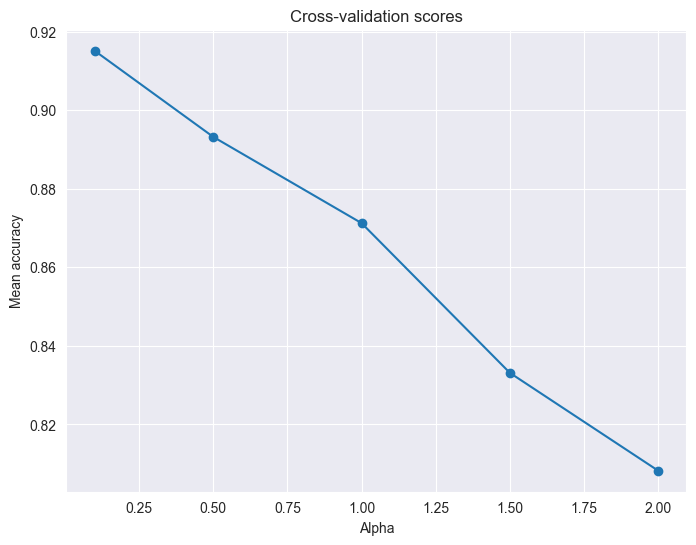

Grid Search Results:


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [51]:
import matplotlib.pyplot as plt

# Assuming grid_search is your GridSearchCV object

# Extract the results of the cross-validation
means = grid_search.cv_results_['mean_test_score']
alphas = [0.1, 0.5, 1.0, 1.5, 2.0]

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(alphas, means, marker='o')
plt.title('Cross-validation scores')
plt.xlabel('Alpha')
plt.ylabel('Mean accuracy')
plt.grid(True)
plt.show()

# Assuming grid_search is your GridSearchCV object

results = grid_search.cv_results_

print("Grid Search Results:")
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Mean accuracy: {mean_score:.4f}, Parameters: {params}")


In [ ]:
# Training accuracy
train_predictions = best_classifier.predict(msg_train)
train_accuracy = accuracy_score(label_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.3f}")


Training Accuracy: 0.975


In [ ]:
from sklearn import metrics
print("Classification Report \n",metrics.classification_report(label_train, train_predictions))
print("\n")
print("Confusion Matrix \n",metrics.confusion_matrix(label_train, train_predictions))
print("\n")
print("Accuracy of Train dataset : {0:0.3f}".format(metrics.accuracy_score(label_train, train_predictions)))

Classification Report 
               precision    recall  f1-score   support

         ham       0.97      0.96      0.97       244
        spam       0.98      0.98      0.98       439

    accuracy                           0.98       683
   macro avg       0.97      0.97      0.97       683
weighted avg       0.98      0.98      0.98       683



Confusion Matrix 
 [[235   9]
 [  8 431]]


Accuracy of Train dataset : 0.975


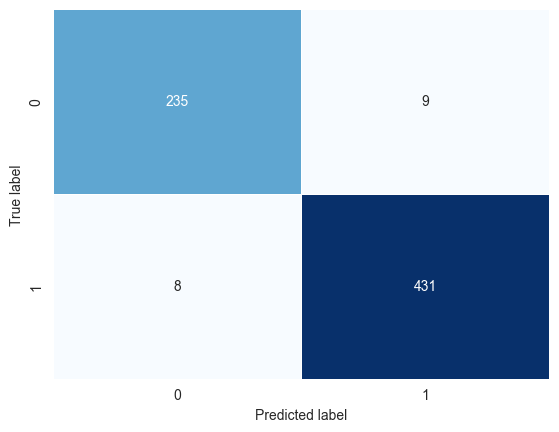

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
   mtx = metrics.confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')
plot_confusion_matrix(label_train, train_predictions)

In [ ]:

label_predictions = best_classifier.predict(msg_test)
print(label_predictions)


['spam' 'ham' 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'ham' 'ham'
 'spam' 'ham' 'spam' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'ham' 'ham'
 'spam' 'ham' 'ham' 'spam' 'ham' 'spam' 'ham' 'spam' 'ham' 'ham' 'spam'
 'spam' 'spam' 'spam' 'ham' 'ham' 'spam' 'ham' 'spam' 'spam' 'ham' 'ham'
 'spam' 'spam' 'spam' 'spam' 'ham' 'spam' 'ham' 'spam' 'ham' 'spam' 'spam'
 'spam' 'ham' 'ham' 'spam' 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'ham' 'ham' 'spam' 'ham'
 'ham' 'ham' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'ham' 'ham' 'ham'
 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'ham' 'ham' 'spam' 'spam'
 'ham' 'ham' 'spam' 'spam' 'spam' 'spam' 'ham' 'spam' 'ham' 'ham' 'spam'
 'spam' 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'ham' 'ham' 'spam'
 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'spam' 'spam' 'spam' 'spam' 'ham'
 'spam' 'spam' 'spam' 'spam' 'ham' 'ham' 's

In [ ]:

test_accuracy = accuracy_score(label_test, label_predictions)
print(f"Test Accuracy: {test_accuracy:.3f}")

Test Accuracy: 0.930


In [ ]:

from sklearn import metrics
print(metrics.classification_report(label_test, label_predictions))
print(metrics.confusion_matrix(label_test, label_predictions))

              precision    recall  f1-score   support

         ham       0.92      0.90      0.91        68
        spam       0.93      0.95      0.94       103

    accuracy                           0.93       171
   macro avg       0.93      0.92      0.93       171
weighted avg       0.93      0.93      0.93       171

[[61  7]
 [ 5 98]]


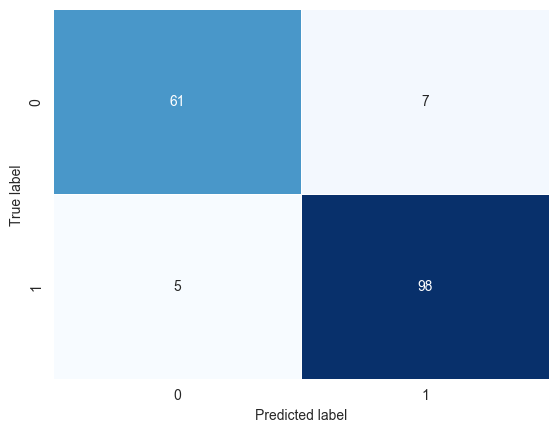

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
   mtx = metrics.confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')
plot_confusion_matrix(label_test, label_predictions)

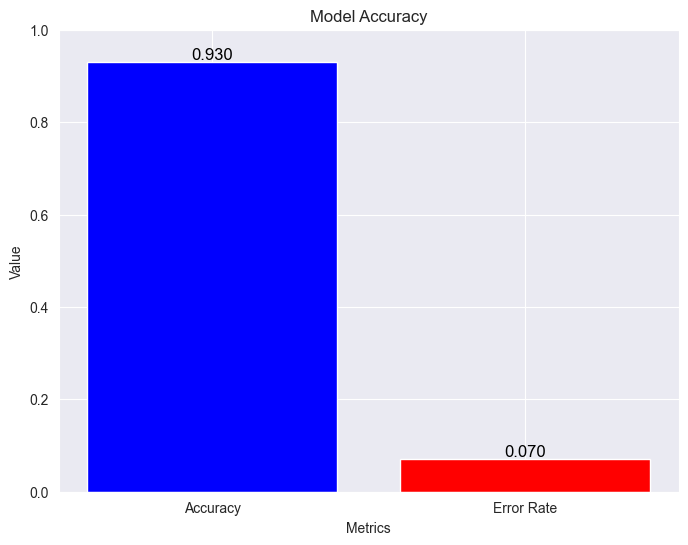

In [ ]:
# Visualize accuracy using a bar chart
accuracies = [test_accuracy, 1 - test_accuracy]  # Accuracy and error rate
labels = ['Accuracy', 'Error Rate']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, accuracies, color=['blue', 'red'])
plt.title('Model Accuracy')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1

# Display exact values on the bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             f'{acc:.3f}', 
             ha='center', 
             va='bottom', 
             color='black',
             fontsize=12)

plt.show()


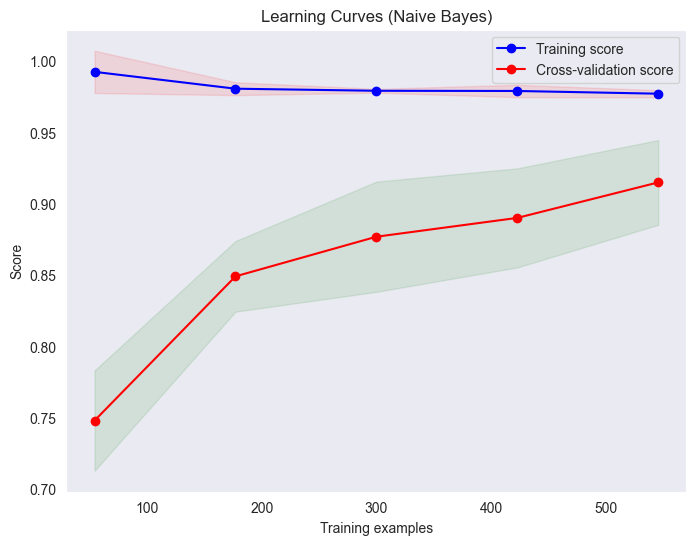

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="red", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Naive Bayes)"
cv = 5  # Cross-validation folds


plot_learning_curve(best_classifier, title, msg_train, label_train, cv=cv)
plt.show()




In [ ]:
import pandas as pd

def learning_curve_table(estimator, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    data = {'Training Size': train_sizes, 'Training Score': train_scores_mean, 'Validation Score': test_scores_mean}
    df = pd.DataFrame(data)
    return df

# Assuming 'best_classifier', 'msg_train', and 'label_train' are defined
cv = 5  # Cross-validation folds
train_sizes = np.linspace(.1, 1.0, 5)  # Vary this if needed

learning_curve_df = learning_curve_table(best_classifier, msg_train, label_train, cv=cv, train_sizes=train_sizes)
print(learning_curve_df)


   Training Size  Training Score  Validation Score
0             54        0.992593          0.748197
1            177        0.980791          0.849270
2            300        0.979333          0.877050
3            423        0.979196          0.890243
4            546        0.977289          0.915114


In [ ]:
import joblib

# Save the model
joblib.dump(best_classifier, 'spam_model.joblib')

# Load the model
loaded_model = joblib.load('spam_model.joblib')
joblib.dump(vectorizer, 'vectorizer.joblib')


['vectorizer.joblib']

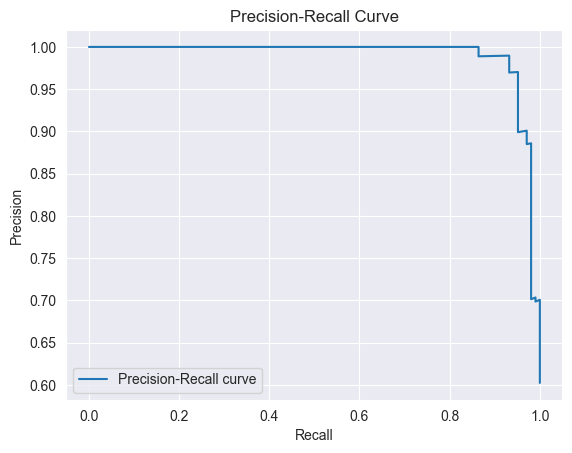

AUC: 0.9898312632454946
Optimal Threshold: 0.6568449587313073


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Assuming model is your trained classifier
y_scores = best_classifier.predict_proba(msg_test)[:, 1]

# Convert string labels to binary values
y_test_binary = label_binarize(label_test, classes=['ham', 'spam'])

# Use OneVsRestClassifier to handle multiclass/multilabel indicators
model = OneVsRestClassifier(best_classifier)

precision, recall, thresholds = precision_recall_curve(y_test_binary, y_scores)

# Plot Precision-Recall Curve
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Calculate AUC (Area Under the Curve) for Precision-Recall Curve
auc_score = auc(recall, precision)
print(f'AUC: {auc_score}')

# Find the threshold for a specific point on the curve (e.g., where precision and recall are balanced)
balance_point_index = np.argmax(precision + recall)
optimal_threshold = thresholds[balance_point_index]
print(f'Optimal Threshold: {optimal_threshold}')
